In [1]:
%cd ..

C:\Users\Brown Research\Documents\vr-exoskeleton


In [2]:
%matplotlib ipympl

# origin

In [3]:
import os

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation

from vr_exoskeleton import data_utils, gaze_modeling, spatial

In [117]:
def negate_axis(df, col):
    df[col] = -df[col]


def load_user(path):
    df = pd.read_csv(path)
    df.drop(columns=['time(100ns)', 'time_stamp(ms)', 'frame'], inplace=True)
    cols_x = [
        'eye_in_head_left_x', 'eye_in_head_right_x',
        'head_x',
        'eye_in_head_left_origin_x', 'eye_in_head_right_origin_x'
    ]
    for col in cols_x:
        negate_axis(df, col)
    return df


def load_obj(path):
    df = pd.read_csv(path)
    df.drop(columns=['time(100ns)', 'time_stamp(ms)'], inplace=True)
    return df


users = ['2025040302', '2025041602', '2025042201']
tasks = ['LinearSmoothPursuit', 'ArcSmoothPursuit', 'RapidVisualSearch', 'RapidVisualSearchAvoidance']
n_trials = 3

user_task_paths = dict()
user_task_paths_obj = dict()
for user in users:
    user_task_paths[user] = dict()
    user_task_paths_obj[user] = dict()
    folder_user = os.path.join('..', 'EyeAndNeckTracking', 'Data', 'Users', user)
    for task in tasks:
        user_task_paths[user][task] = list()
        user_task_paths_obj[user][task] = list()
        for trial in range(n_trials):
            fname = f'User{user}_{task}_{trial:d}.csv'
            path = os.path.join(folder_user, fname)
            df = load_user(path)
            # print(len(df), fname)
            user_task_paths[user][task].append(path)

            fname_obj = f'Object{user}_{task}_{trial:d}.csv'
            path_obj = os.path.join(folder_user, fname_obj)
            df_obj = load_obj(path_obj)
            # print(len(df_obj), fname_obj)
            user_task_paths_obj[user][task].append(path_obj)
    
    print()

In [118]:
df0 = load_user(user_task_paths[users[0]][tasks[0]][0])
df0.head()

,eye_in_head_left_x,eye_in_head_left_y,eye_in_head_left_z,eye_in_head_right_x,eye_in_head_right_y,eye_in_head_right_z,head_x,head_y,head_z,head_rotation_x,...,eye_in_world_right_origin_z,eye_in_world_left_x,eye_in_world_left_y,eye_in_world_left_z,eye_in_world_right_x,eye_in_world_right_y,eye_in_world_right_z,head_origin_x,head_origin_y,head_origin_z
0,-0.004990,-0.030273,0.999527,-0.045029,-0.055283,0.997452,-0.043940,0.173989,0.983767,0.087406,...,-0.027733,-0.038896,0.144141,0.988790,0.001228,0.119509,0.992829,0.089398,1.384589,-0.001335
1,-0.005203,-0.029861,0.999527,-0.041367,-0.061447,0.997238,-0.044462,0.174246,0.983698,0.087536,...,-0.027862,-0.039209,0.144806,0.988669,-0.002944,0.113627,0.993505,0.089369,1.384548,-0.001362
2,-0.006714,-0.033218,0.999420,-0.042358,-0.058762,0.997360,-0.044644,0.174754,0.983599,0.087791,...,-0.027950,-0.037884,0.142005,0.989135,-0.002161,0.116803,0.993140,0.089300,1.384572,-0.001384
3,-0.004593,-0.033173,0.999435,-0.043732,-0.061996,0.997116,-0.045024,0.175704,0.983413,0.088268,...,-0.027986,-0.040397,0.142987,0.988896,-0.001181,0.114532,0.993417,0.089264,1.384591,-0.001419
4,-0.005997,-0.033508,0.999420,-0.041992,-0.060043,0.997299,-0.045413,0.176818,0.983195,0.088830,...,-0.028077,-0.039393,0.143785,0.988824,-0.003335,0.117587,0.993044,0.089210,1.384636,-0.001509


In [119]:
for column in df0.columns:
    print('{}: {}'.format(column, ','.join(map(str, df0[column][:5]))))

eye_in_head_left_x: -0.004989624,-0.005203247,-0.006713867,-0.004592896,-0.005996704
eye_in_head_left_y: -0.03027344,-0.02986145,-0.03321838,-0.03317261,-0.0335083
eye_in_head_left_z: 0.999527,0.999527,0.9994202,0.9994354,0.9994202
eye_in_head_right_x: -0.04502869,-0.04136658,-0.0423584,-0.04373169,-0.04199219
eye_in_head_right_y: -0.05528259,-0.06144714,-0.0587616,-0.06199646,-0.06004333
eye_in_head_right_z: 0.9974518,0.9972382,0.9973602,0.9971161,0.9972992
head_x: -0.04393968,-0.04446153,-0.04464442,-0.04502429,-0.04541305
head_y: 0.1739888,0.1742456,0.174754,0.1757036,0.1768176
head_z: 0.9837669,0.983698,0.9835995,0.983413,0.9831954
head_rotation_x: 0.0874059,0.08753604,0.08779073,0.08826811,0.08882976
head_rotation_y: 0.02183555,0.0221013,0.02220485,0.02241124,0.02261787
head_rotation_z: -0.002553161,-0.002510825,-0.002376667,-0.002198858,-0.002070486
head_rotation_w: -0.9959302,-0.995913,-0.9958887,-0.9958422,-0.9957879
eye_in_head_left_origin_x: -0.03600543,-0.03600223,-0.0360045

User 2025040302; task LinearSmoothPursuit; trial 0


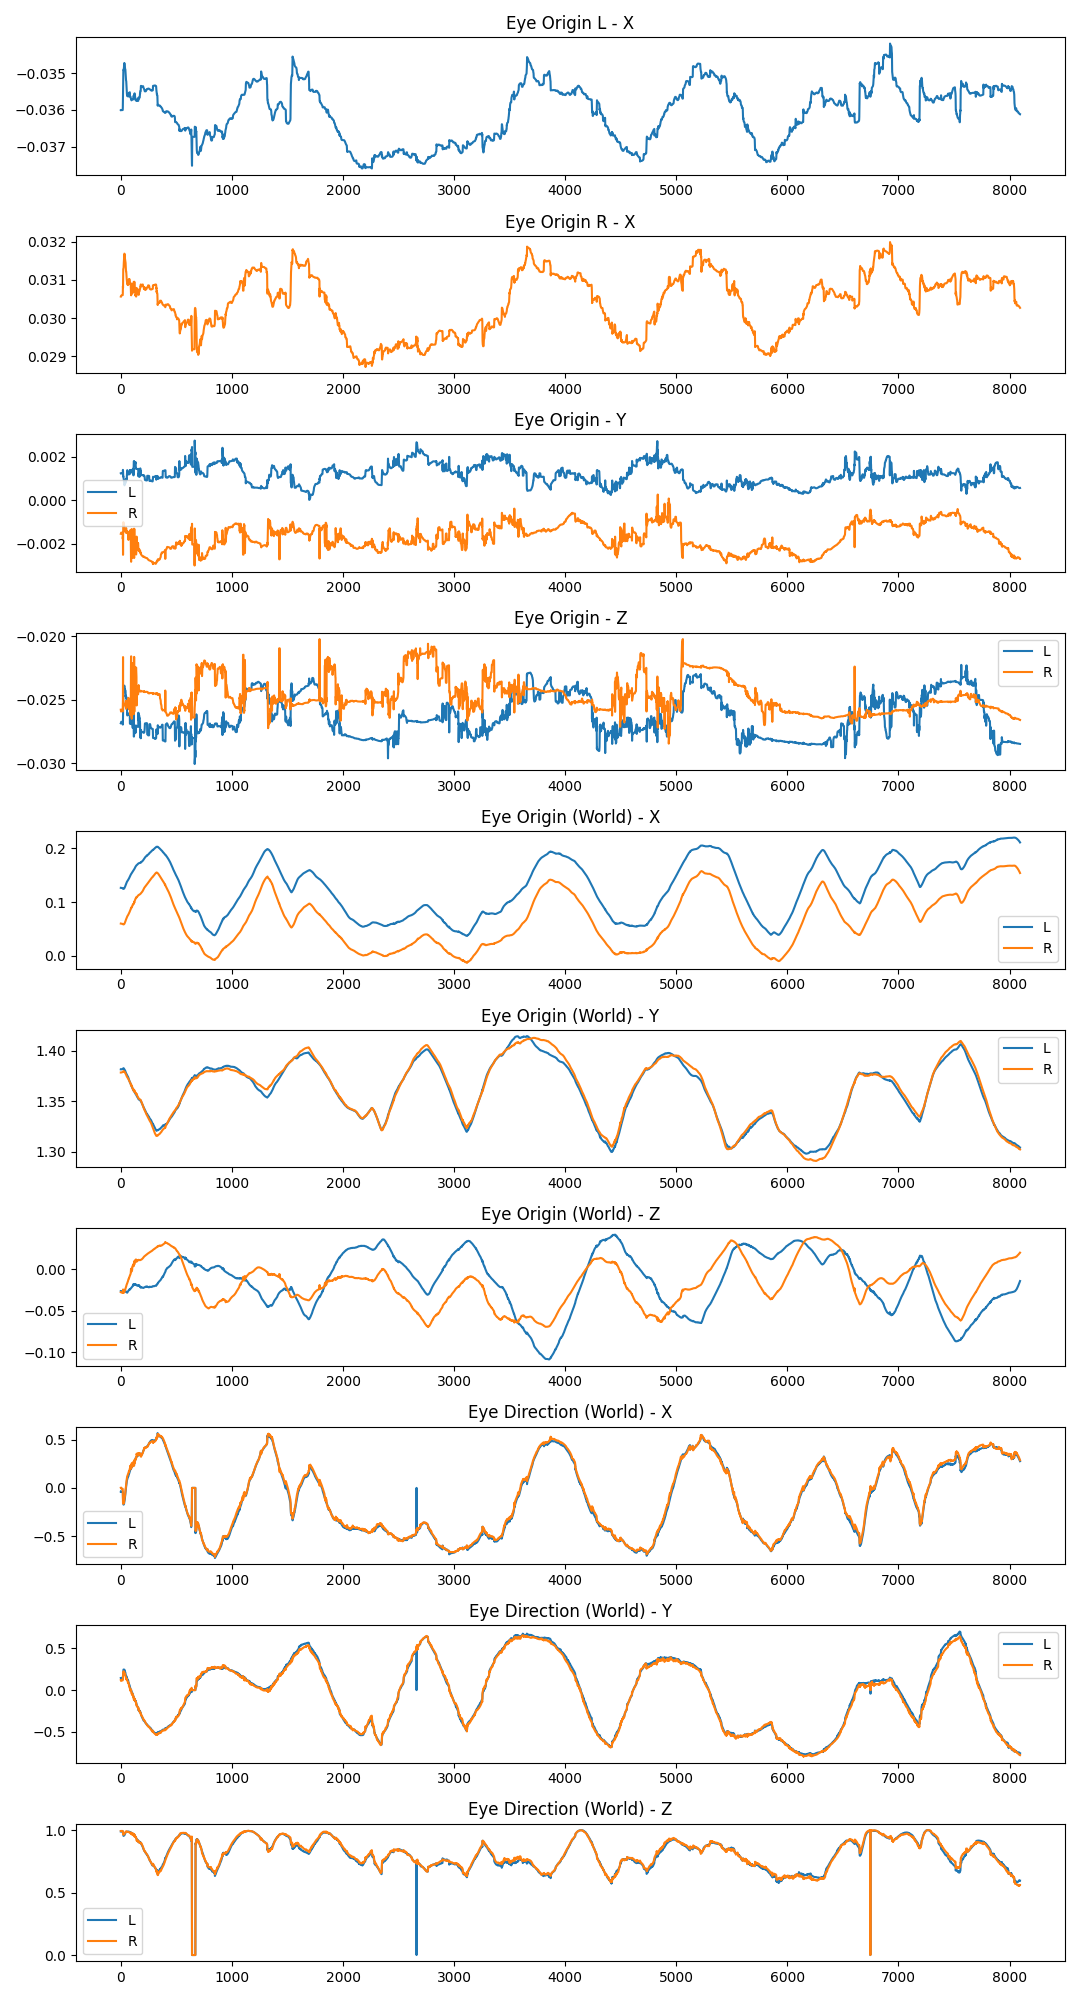

In [120]:
def plot_trajectories(df):
    fig, axes = plt.subplots(10, figsize=(10.8, 2.0 * 10))
    x = np.arange(len(df))
    
    axes[0].plot(x, df['eye_in_head_left_origin_x'])
    axes[0].set_title(f'Eye Origin L - X')
    
    axes[1].plot(x, df['eye_in_head_right_origin_x'], color='C1')
    axes[1].set_title(f'Eye Origin R - X')
    
    axes[2].plot(x, df['eye_in_head_left_origin_y'], label='L')
    axes[2].plot(x, df['eye_in_head_right_origin_y'], label='R')
    axes[2].set_title(f'Eye Origin - Y')
    axes[2].legend()
    
    axes[3].plot(x, df['eye_in_head_left_origin_z'], label='L')
    axes[3].plot(x, df['eye_in_head_right_origin_z'], label='R')
    axes[3].set_title(f'Eye Origin - Z')
    axes[3].legend()
    
    axes[4].plot(x, df['eye_in_world_left_origin_x'], label='L')
    axes[4].plot(x, df['eye_in_world_right_origin_x'], label='R')
    axes[4].set_title(f'Eye Origin (World) - X')
    axes[4].legend()
    
    axes[5].plot(x, df['eye_in_world_left_origin_y'], label='L')
    axes[5].plot(x, df['eye_in_world_right_origin_y'], label='R')
    axes[5].set_title(f'Eye Origin (World) - Y')
    axes[5].legend()
    
    axes[6].plot(x, df['eye_in_world_left_origin_z'], label='L')
    axes[6].plot(x, df['eye_in_world_right_origin_z'], label='R')
    axes[6].set_title(f'Eye Origin (World) - Z')
    axes[6].legend()
    
    axes[7].plot(x, df['eye_in_world_left_x'], label='L')
    axes[7].plot(x, df['eye_in_world_right_x'], label='R')
    axes[7].set_title(f'Eye Direction (World) - X')
    axes[7].legend()
    
    axes[8].plot(x, df['eye_in_world_left_y'], label='L')
    axes[8].plot(x, df['eye_in_world_right_y'], label='R')
    axes[8].set_title(f'Eye Direction (World) - Y')
    axes[8].legend()
    
    axes[9].plot(x, df['eye_in_world_left_z'], label='L')
    axes[9].plot(x, df['eye_in_world_right_z'], label='R')
    axes[9].set_title(f'Eye Direction (World) - Z')
    axes[9].legend()
    
    plt.tight_layout()
    plt.show()


print(f'User {users[0]}; task {tasks[0]}; trial 0')
plot_trajectories(df0)

In [92]:
row0 = df0.iloc[0]
row0['eye_in_head_left_origin_x'], row0['eye_in_world_left_origin_x'], row0['head_origin_x']

(0.03600543, 0.1265465, 0.0893979764563806)

In [93]:
row0['eye_in_head_left_origin_x'] + row0['head_origin_x'], row0['eye_in_world_left_origin_x']

(0.1254034064563806, 0.1265465)

In [94]:
row0 = df0.iloc[15]
[(row0[f'eye_in_head_left_origin_{dim}'] + row0[f'head_origin_{dim}'], row0[f'eye_in_world_left_origin_{dim}']) for dim in ('x', 'y', 'z')]

[(0.1247962926922013, 0.1260146),
 (1.386478358470589, 1.381864),
 (-0.028701788786995, -0.02678262)]

In [110]:
[row0[f'head_rotation_{dim}'] for dim in ['x', 'y', 'z', 'w']]

[0.0920109, 0.02339747, -0.002153354, -0.9954808]

## Distributions

In [13]:
def _vector(df, name, sep, dims):
    cols = [f'{name}{sep}{axis}' for axis in dims]
    return df[cols].to_numpy()

def vector3(df, name, sep='_'):
    return _vector(df, name, sep, ('x', 'y', 'z'))

def vector_rotation(df, name, sep='_'):
    return _vector(df, name, sep, ('x', 'y', 'z', 'w'))

In [14]:
def points_distance(points1, points2):
    return np.sqrt(np.sum((points1 - points2) ** 2, axis=1))

In [109]:
def flatten_trials(user, data_fn):
    for task in tasks:
        for path in user_task_paths[user][task]:
            df = load_user(path)
            yield data_fn(df)

In [16]:
def remove_outliers(a, c=10.0):
    mean, std = np.mean(a), np.std(a)
    inlier = (a > mean - c * std) & (a < mean + c * std)
    return a[inlier], a[~inlier], mean, std

#### Inter-pupilary Distance

How far apart are peoples' eyes?

User 2025040302 ; mean: 0.06642210251595643 ; std: 0.0003130778442010544 ; # of inliers: 97125 ; # of outliers: 7
User 2025041602 ; mean: 0.06493718959638357 ; std: 0.0005792315792566301 ; # of inliers: 97141 ; # of outliers: 21
User 2025042201 ; mean: 0.06227602460711061 ; std: 0.0002384220365178021 ; # of inliers: 97155 ; # of outliers: 29


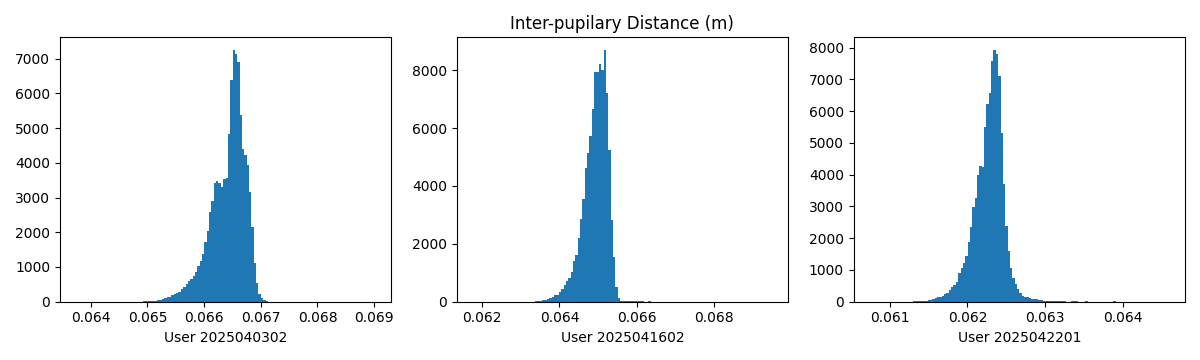

In [17]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))

def data_fn_eye_distance(df):
    eye_distance = points_distance(vector3(df, 'eye_in_world_left_origin'), vector3(df, 'eye_in_world_right_origin'))
    assert np.allclose(eye_distance, points_distance(vector3(df, 'eye_in_head_left_origin'), vector3(df, 'eye_in_head_right_origin')))
    return eye_distance

for i, user in enumerate(users):
    trial_eye_distance = list(flatten_trials(user, data_fn_eye_distance))
    eye_distance_all = np.concatenate(trial_eye_distance)
    inliers, outliers, mean, std = remove_outliers(eye_distance_all)
    axes[i].hist(inliers, bins=128, color='C0')
    axes[i].set_xlabel(f'User {user}')
    print('User', user, '; mean:', mean, '; std:', std, '; # of inliers:', len(inliers), '; # of outliers:', len(outliers))

axes[1].set_title('Inter-pupilary Distance (m)')
plt.tight_layout()
plt.show()

#### Head-to-eye Distance

How far from each eye is the origin of the head?

Left eye distance mean: 0.043349155313959276 ; std: 0.0015039105115205234 ; # of inliers: 97132 ; # of outliers: 0
Right eye distance mean: 0.03937126478915816 ; std: 0.0011764167374252498 ; # of inliers: 97132 ; # of outliers: 0
Left eye distance mean: 0.039224925360185806 ; std: 0.0014104863718646912 ; # of inliers: 97151 ; # of outliers: 11
Right eye distance mean: 0.04159112850713607 ; std: 0.0010836425481804746 ; # of inliers: 97149 ; # of outliers: 13
Left eye distance mean: 0.04257844382647464 ; std: 0.0008431481463168898 ; # of inliers: 97133 ; # of outliers: 51
Right eye distance mean: 0.04099875108271629 ; std: 0.0008334604767865382 ; # of inliers: 97163 ; # of outliers: 21


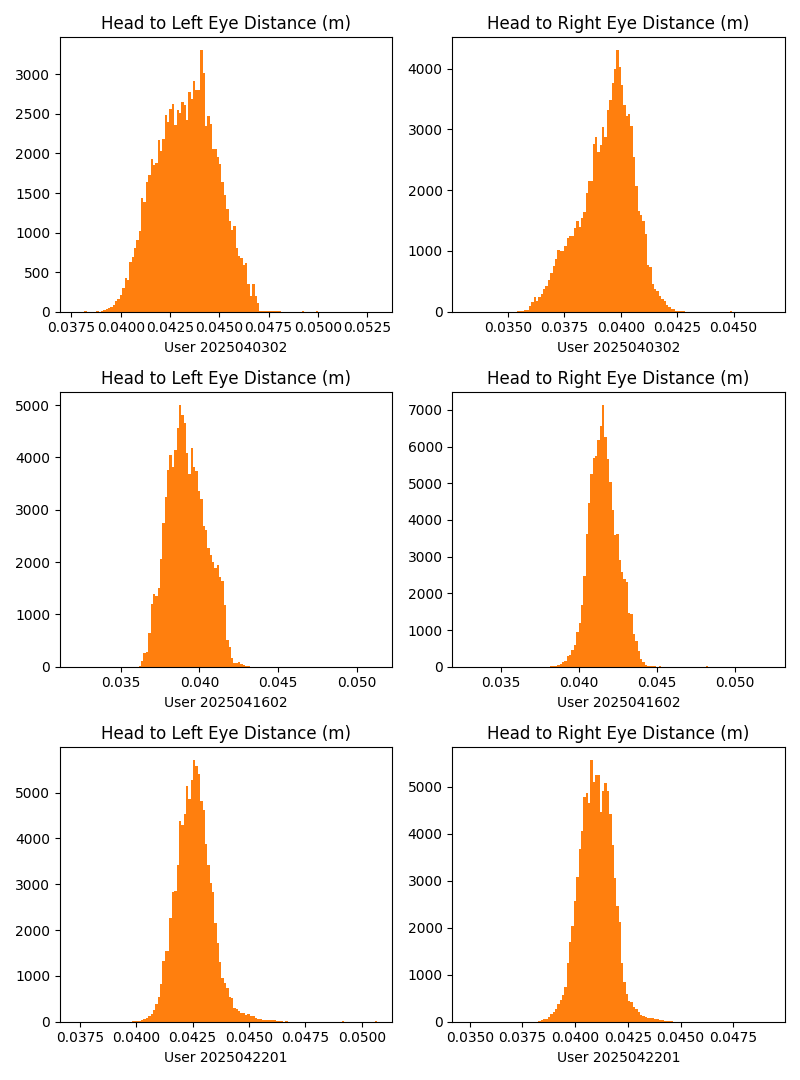

In [96]:
plt.close()
fig, axes = plt.subplots(3, 2, figsize=(8, 10.8))

def data_fn_head_eye_distance(df):
    head_eye_left_distance = points_distance(vector3(df, 'head_origin'), vector3(df, 'eye_in_world_left_origin'))
    head_eye_right_distance = points_distance(vector3(df, 'head_origin'), vector3(df, 'eye_in_world_right_origin'))
    return head_eye_left_distance, head_eye_right_distance

for i, user in enumerate(users):
    trial_head_eye_left_distance, trial_head_eye_right_distance = zip(*flatten_trials(user, data_fn_head_eye_distance))
    head_eye_left_distance_all = np.concatenate(list(trial_head_eye_left_distance))
    head_eye_right_distance_all = np.concatenate(list(trial_head_eye_right_distance))
    held_inliers, held_outliers, held_mean, held_std = remove_outliers(head_eye_left_distance_all)
    herd_inliers, herd_outliers, herd_mean, herd_std = remove_outliers(head_eye_right_distance_all)
    axes[i][0].hist(held_inliers, bins=128, color='C1')
    axes[i][1].hist(herd_inliers, bins=128, color='C1')
    axes[i][0].set_title('Head to Left Eye Distance (m)')
    axes[i][1].set_title('Head to Right Eye Distance (m)')
    axes[i][0].set_xlabel(f'User {user}')
    axes[i][1].set_xlabel(f'User {user}')
    print('Left eye distance mean:', held_mean, '; std:', held_std, '; # of inliers:', len(held_inliers), '; # of outliers:', len(held_outliers))
    print('Right eye distance mean:', herd_mean, '; std:', herd_std, '; # of inliers:', len(herd_inliers), '; # of outliers:', len(herd_outliers))
plt.tight_layout()
plt.show()

#### Tilt

How tilted are peoples' heads?

User: 2025040302 ; mean: -0.005013408197092617 ; std: 0.005381962360664376 ; # of inliers: 97132 ; # of outliers: 0
User: 2025041602 ; mean: -0.0009217374693810339 ; std: 0.004569210561184496 ; # of inliers: 97162 ; # of outliers: 0
User: 2025042201 ; mean: 0.010577081217072768 ; std: 0.004292926374839343 ; # of inliers: 97183 ; # of outliers: 1


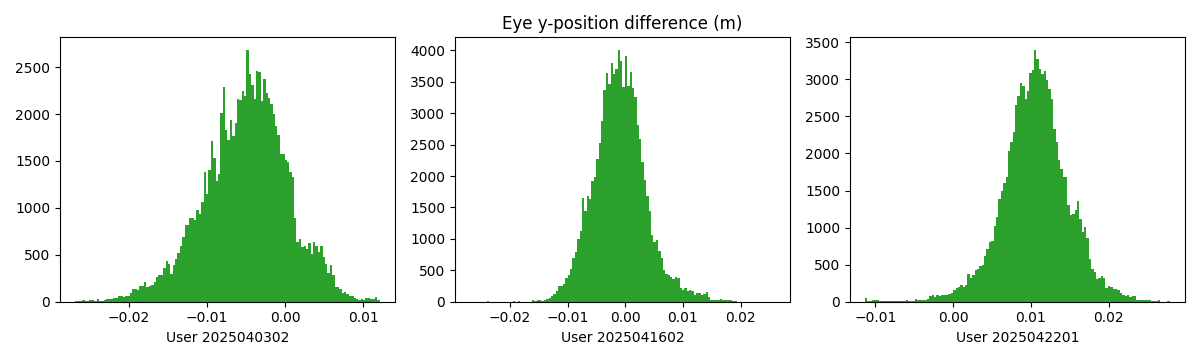

In [22]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))

def data_fn_eye_y_diff(df):
    return df['eye_in_world_right_origin_y'].to_numpy() - df['eye_in_world_left_origin_y'].to_numpy()

for i, user in enumerate(users):
    trial_y_diff = list(flatten_trials(user, data_fn_eye_y_diff))
    inliers, outliers, mean, std = remove_outliers(np.concatenate(trial_y_diff))
    print('User:', user, '; mean:', mean, '; std:', std, '; # of inliers:', len(inliers), '; # of outliers:', len(outliers))
    axes[i].hist(inliers, bins=128, color='C2')
    axes[i].set_xlabel(f'User {user}')

axes[1].set_title('Eye y-position difference (m)')
plt.tight_layout()
plt.show()

#### Pupil Angle from Head

Where are the eyes relative to the head?

Mean left: [ 0.03532695  0.00364703 -0.02478334]
Mean right: [-0.030932   -0.00060822 -0.02428921]
Mean left: [ 0.031268   -0.00073946 -0.02363204]
Mean right: [-0.03364768 -0.00047236 -0.02439187]
Mean left: [ 0.03211912 -0.00299114 -0.02772827]
Mean right: [-0.0298891   0.00264301 -0.02789513]


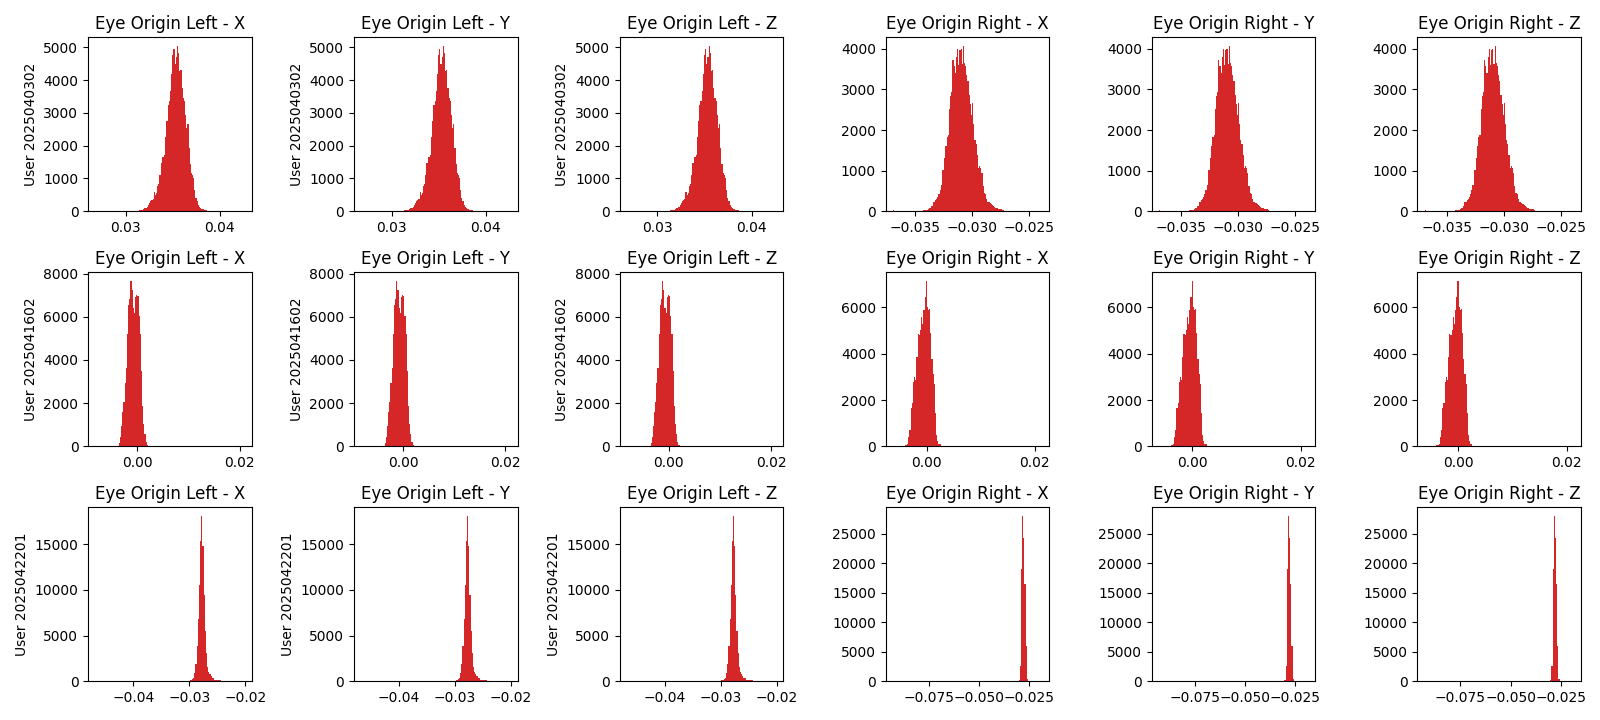

In [103]:
plt.close()
fig, axes = plt.subplots(3, 6, figsize=(16, 7.2))

def data_fn_eye_in_head_origin(df):
    return vector3(df, 'eye_in_head_left_origin'), vector3(df, 'eye_in_head_right_origin')

for i, user in enumerate(users):
    eye_h_l_origin, eye_h_r_origin = map(np.concatenate, zip(*flatten_trials(user, data_fn_eye_in_head_origin)))
    print('Mean left:', np.mean(eye_h_l_origin, axis=0))
    print('Mean right:', np.mean(eye_h_r_origin, axis=0))
    for j, dim in enumerate(['X', 'Y', 'Z']):
        axes[i][j].hist(eye_h_l_origin[:, i], bins=128, color='C3')
        axes[i][j].set_title(f'Eye Origin Left - {dim}')
        axes[i][j].set_ylabel(f'User {user}')
        axes[i][3 + j].hist(eye_h_r_origin[:, i], bins=128, color='C3')
        axes[i][3 + j].set_title(f'Eye Origin Right - {dim}')

plt.tight_layout()
plt.show()

#### Head Position

(97132, 3)
Mean: [ 0.03805458  1.38089526 -0.04849861]
(97162, 3)
Mean: [-0.02793426  1.31931773 -0.12366713]
(97184, 3)
Mean: [ 0.11613559  1.34238073 -0.31820815]


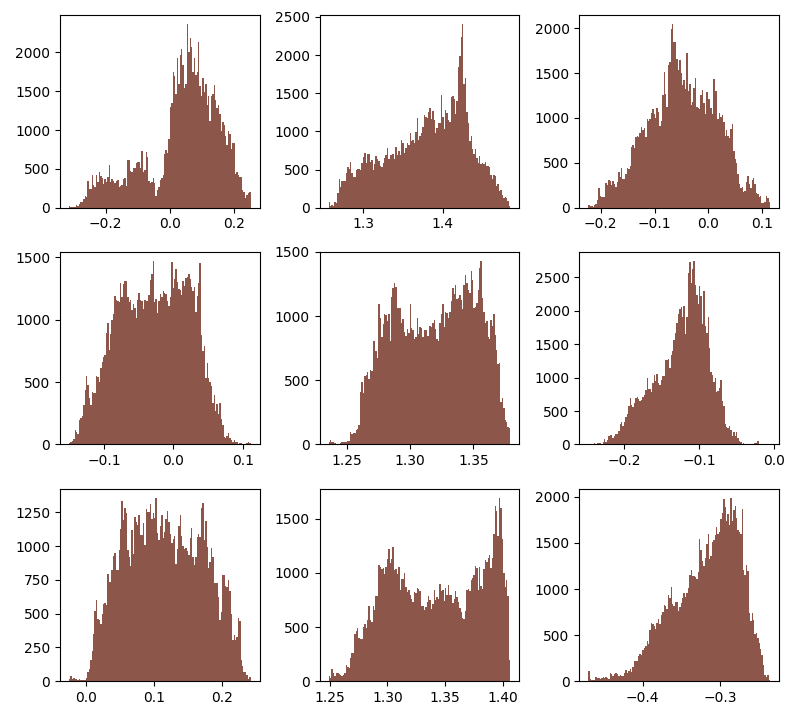

In [106]:
plt.close()
fig, axes = plt.subplots(3, 3, figsize=(8, 7.2))

def data_fn_head_origin(df):
    return vector3(df, 'head_origin')

for i, user in enumerate(users):
    head_origin = np.concatenate(list(flatten_trials(user, data_fn_head_origin)))
    print('Mean:', np.mean(head_origin, axis=0))
    for j, dim in enumerate(['x', 'y', 'z']):
        axes[i][j].hist(head_origin[:, j], bins=128, color='C5')

plt.tight_layout()
plt.show()

In [70]:
atol = 1e-05
np.allclose(eye_h_l_origin, eye_l_origin_trans, atol=atol), np.allclose(eye_h_r_origin, eye_r_origin_trans, atol=atol)

(True, True)

## Autoregressive

In [ ]:
model = gaze_modeling.GazeMLP()
weights = torch.load('output/runs/1745426038_mlp_90hz-angle-h_s49/val_best.pth', weights_only=True)
model.load_state_dict(weights)
user = users[0]
task = 'LinearSmoothPursuit'

paths = user_task_paths[user][task]
paths_obj = user_task_paths_obj[user][task]
for path, path_obj in zip(paths, paths_obj):
    df = load_user(path)
    df_obj = load_obj(path_obj)
    gaze_l_raw, gaze_r_raw, head = vector3(df, 'eye_in_head_left'), vector3(df, 'eye_in_head_right'), vector3(df, 'head')
    # mask_l = df['eye_in_head_left_z'] != 0.0
    # mask_r = df['eye_in_head_right_z'] != 0.0
    # gaze_l = data_utils.interpolate_points(gaze_l_raw, mask_l, normalize=True)
    # gaze_r = data_utils.interpolate_points(gaze_r_raw, mask_r, normalize=True)
    # X = np.concatenate([gaze_l, gaze_r, head], axis=1)
    X = np.concatenate([gaze_l_raw, gaze_r_raw, head], axis=1)
    
    loss = list()
    Y = vector3(df_obj, 'object1', sep='.')
    

## Focus

Determine where in 3D space the eyes are focused.

See: [SO answer](https://stackoverflow.com/a/29449042/1559071)

In [ ]:
def mask_not_blinking(df_):
    return (df_['eye_in_head_left_z'] != 0.0) & (df_['eye_in_head_right_z'] != 0.0)

def mask_not_blinking_world(df_):
    return (df_['eye_in_world_left_z'] != 0.0) & (df_['eye_in_world_right_z'] != 0.0)


# for fname, path in zip(fnames, paths):
#     df = load_user(path)
#     mask = mask_not_blinking(df)
#     mask_world = mask_not_blinking_world(df)
#     assert all(mask == mask_world)

In [ ]:
def mask_skew_gaze(df_):
    return ((df_['eye_in_world_left_x'] != df_['eye_in_world_right_x']) |
            (df_['eye_in_world_left_y'] != df_['eye_in_world_right_y']) |
            (df_['eye_in_world_left_z'] != df_['eye_in_world_right_z']))


# for fname, path in zip(fnames, paths):
#     df = load_user(path)
#     df_open = df[mask_not_blinking_world(df)]
#     mask = mask_skew_gaze(df_open)
#     if not all(mask):
#         print(fname)
#         print(df_open[~mask])

In [ ]:
def get_coefficients_foci(df):
    # Calculate ray of focal point.
    p_l = vector3(df, 'eye_in_world_left_origin')  # p1 - left eye origin
    p_r = vector3(df, 'eye_in_world_right_origin')  # p2 - right eye origin
    g_l = vector3(df, 'eye_in_world_left')  # d1 - left eye direction
    g_r = vector3(df, 'eye_in_world_right')  # d2 - right eye direction
    g_f = np.cross(g_l, g_r, axis=1)  # d3 - focal segment (perpendicular to both gaze rays) direction
    norm_f = np.linalg.norm(g_f, axis=1)[:, np.newaxis]
    g_f /= norm_f

    # Solve for lengths of rays.
    A = np.transpose([g_l, -g_r, g_f], (1, 2, 0))
    b = p_r - p_l
    c_l, c_r, c_f = np.transpose(np.linalg.solve(A, b))

    p_f = p_l + c_l[:, np.newaxis] * g_l
    assert np.allclose(p_f + c_f[:, np.newaxis] * g_f, p_r + c_r[:, np.newaxis] * g_r)

    c_f_half = c_f / 2
    return c_l, c_r, c_f, p_f + c_f_half[:, np.newaxis] * g_f

In [ ]:
masks = list()
trial_coefficients_foci = list()
for path in paths:
    df = load_user(path)
    mask = mask_not_blinking(df)
    masks.append(mask)
    trial_coefficients_foci.append(get_coefficients_foci(df[mask]))

index = 18
trial_coefficients_foci[index][0][:6], trial_coefficients_foci[index][1][:6]  # (df_index, (d_l, d_r, d_f, p_f_midpoint))

In [ ]:
trial_coefficients_foci[index][3][:6]

## Interpolate

When one or both eyes were closed, linearly interpolate between previous and future focal points.

In [ ]:
def interpolate_points(points, mask):
    n = len(mask)
    indices = np.arange(n)[mask]
    
    points_interp = np.zeros((n, 3), dtype=points.dtype)

    # Fill in known focal points.
    points_interp[indices] = points
    
    # Extrapolate before the beginning.
    if indices[0] != 0:
        points_interp[:indices[0]] = points[0]
    
    # Extrapolate after the end.
    if indices[-1] != n - 1:
        points_interp[indices[-1]:] = points[-1]
    
    i_prev, point_prev = indices[0], points[0]
    for i, point in zip(indices[1:], points[1:]):
        if i_prev != i - 1:
            num = i - i_prev  # Starting point is included in `linspace` calculation.
            interp = np.linspace(point_prev, point, num=num, endpoint=False)
            points_interp[i_prev + 1:i] = interp[1:]  # Exclude starting point.
        i_prev, point_prev = i, point

    return points_interp


trial_foci = [coefficients_foci[3] for coefficients_foci in trial_coefficients_foci]
trial_foci_interp = [interpolate_points(foci, mask) for foci, mask in zip(trial_foci, masks)]
len(trial_foci[index]), len(trial_foci_interp[index])

In [ ]:
indices_open = np.arange(len(masks[index]))[masks[index]]
blink_intervals = [(i, j) for i, j in zip(indices_open[:-1], indices_open[1:]) if i + 1 != j]
len(blink_intervals), blink_intervals[:5]

In [ ]:
trial_foci[index][blink_intervals[0][0] - 5:blink_intervals[0][0] + 5]

In [ ]:
trial_foci_interp[index][blink_intervals[0][0] - 2:blink_intervals[0][1] + 2]

In [ ]:
df = load_user(paths[index])
plt.plot(np.arange(len(trial_foci_interp[index])), trial_foci_interp[index][:, 2])
plt.plot(np.arange(len(df)), df['eye_in_world_left_origin_z'])
plt.show()

In [ ]:
trialj_focal_z_bound = np.maximum(-10.0, np.minimum(10, trial_points_interp[index][:, 2]))

plt.figure(figsize=(10.8, 7.2))
plt.plot(np.arange(len(trial_points_interp[index])), trialj_focal_z_bound)
plt.plot(np.arange(len(dfs[index])), dfs[index]['eye_in_world_left_origin_z'])
plt.show()

In [ ]:
plt.hist(trialj_focal_z_bound, bins=128)
plt.show()

In [ ]:
y_min, y_max = -10, 10
step = 3

fig, axes = plt.subplots(len(dfs) // step, 2, width_ratios=[0.7, 0.3], figsize=(14.4, len(dfs) // step * 4.8))
sources = tuple(zip(trial_fnames, dfs, trial_points_interp))
i = 0
while i < len(sources):
    fname, df, points_interp = sources[i]
    
    x = np.arange(len(df))
    fname_base = fname[:fname.index('.')]
    eye_origin = np.mean([df['eye_in_world_left_origin_z'].to_numpy(), df['eye_in_world_right_origin_z'].to_numpy()], axis=0)
    points_z_bound = np.maximum(y_min, np.minimum(y_max, points_interp[:, 2]))

    ax = axes[i // step]
    ax[0].plot(x, points_z_bound)
    ax[0].plot(x, eye_origin)
    ax[0].set_title(f'[{fname_base}] Gaze Focal Point Trajectory (z)')
    ax[0].set_ylabel('Meters (z)')

    ax[1].hist(points_z_bound, bins=128, density=True)
    ax[1].set_title('Density (z)')

    if i + step >= len(sources):
        ax[0].set_xlabel('Frame')
        ax[1].set_xlabel('Meters (z)')

    i += step

### Sanity Check

In [ ]:
rng = np.random.default_rng()

In [ ]:
index = rng.integers(len(dfs))
fname, df, mask, points_interp, c_l, c_r, c_f = trial_fnames[index], dfs[index], masks[index], trial_points_interp[index], *fcps[index][:3]
n = len(df)

# Fill blinking coefficients with zero.
c_l_ = np.zeros(n, dtype=c_l.dtype)
c_l_[mask] = c_l
c_r_ = np.zeros(n, dtype=c_r.dtype)
c_r_[mask] = c_r
c_f_ = np.zeros(n, dtype=c_f.dtype)
c_f_[mask] = c_f

p_l = vector3(df, 'eye_in_world_left_origin')
p_r = vector3(df, 'eye_in_world_right_origin')
g_l = vector3(df, 'eye_in_world_left')
g_r = vector3(df, 'eye_in_world_right')

# Re-order (x, y, z) to (x, z, y) for better visualization of axes.
p_l_ = np.stack([p_l[:, 0], p_l[:, 2], p_l[:, 1]], axis=1)
p_r_ = np.stack([p_r[:, 0], p_r[:, 2], p_r[:, 1]], axis=1)
g_l_ = np.stack([g_l[:, 0], g_l[:, 2], g_l[:, 1]], axis=1)
g_r_ = np.stack([g_r[:, 0], g_r[:, 2], g_r[:, 1]], axis=1)
foci = np.stack([points_interp[:, 0], points_interp[:, 2], points_interp[:, 1]], axis=1)

t = 0
step = 1

n, foci.shape, c_l_.shape, c_r_.shape, c_f_.shape

In [ ]:
df_object = pd.read_csv(trial_fnames_object[index])
print(len(df_object))
df_object.head()

In [ ]:
fig = plt.figure(figsize=(10.8, 7.2))
ax = fig.add_subplot(projection='3d')

line_gaze_l, = ax.plot([], [], [], marker='+', linestyle='--')
line_gaze_r, = ax.plot([], [], [], marker='+', linestyle='--')
# line_gaze = ax.quiver([], [], [], [], [], [])
# point_f = ax.scatter(*foci[t])
point_f = ax.scatter([], [], [])

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

In [ ]:
plt.close()

t = (t + step) % n
while not mask[t]:
    t = (t + step) % n

print(fname)
print('t =', t)
print('Eye L Origin:', *p_l[t])
print('Eye L Direction:', *g_l[t])
print('Eye L Magnitude:', c_l_[t])
print('Eye R Origin:', *p_r[t])
print('Eye R Direction:', *g_r[t])
print('Eye R Magnitude:', c_r_[t])

fig = plt.figure(figsize=(10.8, 7.2))
ax = fig.add_subplot(projection='3d')

ax.plot(*zip(p_l_[t], p_l_[t] + c_l_[t] * g_l_[t]), marker='+', linestyle='--')
ax.plot(*zip(p_r_[t], p_r_[t] + c_r_[t] * g_r_[t]), marker='+', linestyle='--')

ax.scatter(*foci[t])

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

# line_gaze_l.set_data_3d(*zip(p_l_[t], p_l_[t] + c_l_[t] * g_l_[t]))
# line_gaze_r.set_data_3d(*zip(p_r_[t], p_r_[t] + c_r_[t] * g_r_[t]))

# point_f.set(*foci[t])

plt.show()

In [ ]:
point_f.get_paths()

## Calculate Head Origin (mutates)

In [82]:
# q24 = Rotation.from_quat(vector_rotation(df24, 'head_rotation'))
# eye_h_l_origin24 = vector3(df24, 'eye_in_head_left_origin')
# eye_w_l_origin24 = vector3(df24, 'eye_in_world_left_origin')
# eye_h_r_origin24 = vector3(df24, 'eye_in_head_right_origin')
# eye_w_r_origin24 = vector3(df24, 'eye_in_world_right_origin')
# head_origin24 = vector3(df24, 'head_origin')

# head_origin_hat_l24 = eye_w_l_origin24 - q24.apply(eye_h_l_origin24)
# head_origin_hat_r24 = eye_w_r_origin24 - q24.apply(eye_h_r_origin24)
# np.allclose(head_origin_hat_l24, head_origin24), np.allclose(head_origin_hat_r24, head_origin24), np.allclose(head_origin_hat_l24, head_origin_hat_r24)

(True, True, True)

In [83]:
# np.allclose((head_origin_hat_l24 + head_origin_hat_r24) / 2, head_origin24)

True

In [87]:
# for user in users[:2]:
#     folder_user = os.path.join('..', 'EyeAndNeckTracking', 'Data', 'Users', user)
#     for task in tasks:
#         for trial in range(n_trials):
#             fname = f'User{user}_{task}_{trial:d}.csv'
#             path = os.path.join(folder_user, fname)
#             df = pd.read_csv(path)
            
#             q = Rotation.from_quat(vector_rotation(df, 'head_rotation'))
#             eye_h_l_origin = vector3(df, 'eye_in_head_left_origin')
#             eye_w_l_origin = vector3(df, 'eye_in_world_left_origin')
#             head_origin_hat_l = eye_w_l_origin - q.apply(eye_h_l_origin)
#             eye_h_r_origin = vector3(df, 'eye_in_head_right_origin')
#             eye_w_r_origin = vector3(df, 'eye_in_world_right_origin')
#             head_origin_hat_r = eye_w_r_origin - q.apply(eye_h_r_origin)
#             head_origin_hat = (head_origin_hat_l + head_origin_hat_r) / 2
#             for i, dim in enumerate(['x', 'y', 'z']):
#                 df[f'head_origin_{dim}'] = head_origin_hat[:, i]

#             df.to_csv(os.path.join(folder_user, f'User{user}_{task}_{trial:d}.csv'), index=False)